# PyTorch Workflow

In [ ]:
what_we_covering = {1: "data{prepare and load}",
                    2: "build model",
                    3: "fitting the model to data(training)",
                    4: "making prediction and evaluating a model",
                    5: "saving and loading model",
                    6: "putting it all together"}

what_we_covering

{1: 'data{prepare and load}',
 2: 'build model',
 3: 'fitting the model to data(training)',
 4: 'making prediction and evaluating a model',
 5: 'saving and loading model',
 6: 'putting it all together'}

In [ ]:
import torch
from torch import nn ## Neural Networks
import matplotlib.pyplot as plt

## Data Preparing and Loading

In [ ]:
# Create a known parameter.
weight = 0.7
bias = 0.3

# Create datasets.
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [ ]:
len(X)

50

In [ ]:
len(y)

50

## Splitting data into train and test

In [ ]:
# Create a train, test, split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(X_test), len(y_train), len(y_test)

(40, 10, 40, 10)

## Visualize the data

In [ ]:
def plot_predictions( train_data = X_train,
                      train_labels = y_train,
                      test_data = X_test,
                      test_labels = y_test,
                      predictions = None):
  plt.figure(figsize=(10, 7))

  #Plot training data in Blue.
  plt.scatter(train_data, train_labels, c='b', s=4, label="Training data")

  #Plot test data in green.
  plt.scatter(test_data, test_labels, c='g', s=4, label="Testing data")

  # Are there any predictions.
  if predictions is not None:
    # Plot predictions if they exist.
    plt.scatter(test_data, predictions, c='r', s=4, label='Predcitions')

  #Show legend.
  plt.legend(prop={"size": 14})

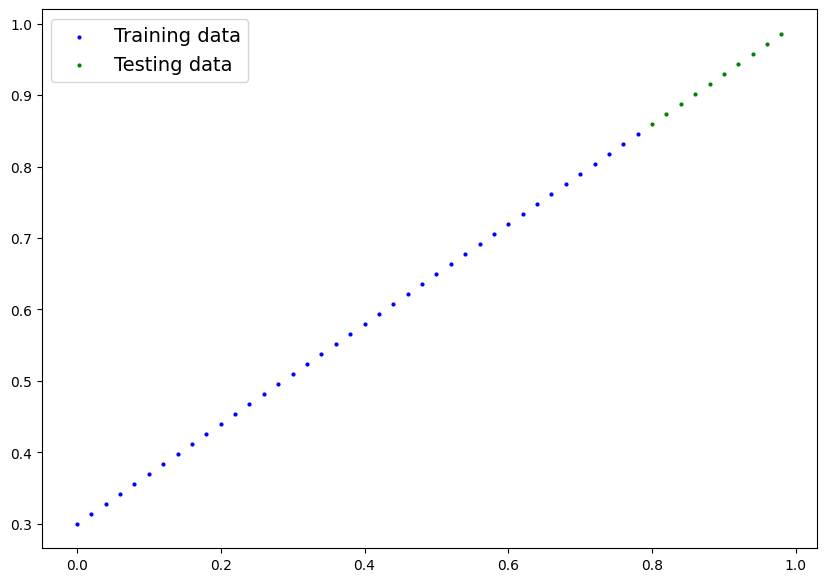

In [ ]:
plot_predictions()

## Creating a model

What our model does?
* Start with random values (weight, bias)
* Look at the training data and adjust the random values to better represent the weight and bias.

How does it do?
1. Gradient Descent.
2. Backpropagation.

In [ ]:
# Create linear regression model class
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1, #Starts with a random value
                                            requires_grad = True, #Using Gradient Descent.
                                            dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad = True,
                                         dtype = torch.float))

  #Forward method to define the computation in the model.
  def forward(self, x:torch.Tensor) -> torch.Tensor:
    return self.weights * x +self.bias

### PyTorch Model building essentials.

* torch.nn contains all of the buildings for the computational graphs.
* torch.nn.Parameter - what should our model try and learn
* torch.nn.Module - base class for all neural network.
* torch.optim - optimizers in PyTorch.
* def forward() - all nn.Module subclasses require you to overwrite forward(), this method defines what happens in the forward computation.

**LINK: **https://pytorch.org/tutorials/beginner/ptcheat.html

In [ ]:
# Checking the contents of PyTorch model.
# Create a random seed.
torch.manual_seed(42)

# Create an instance of the model.
model_0 = LinearRegressionModel()

#Check out parameters.
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [ ]:
# List named parameters.
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making prediction using `torch.inference_model()`

- Pass the data to the model then it going to run it through the `forward()` method.

In [ ]:
with torch.inference_mode(): #disables all the essential during training.
  # Benefit: Large dataset prediction faster.
  y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [ ]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

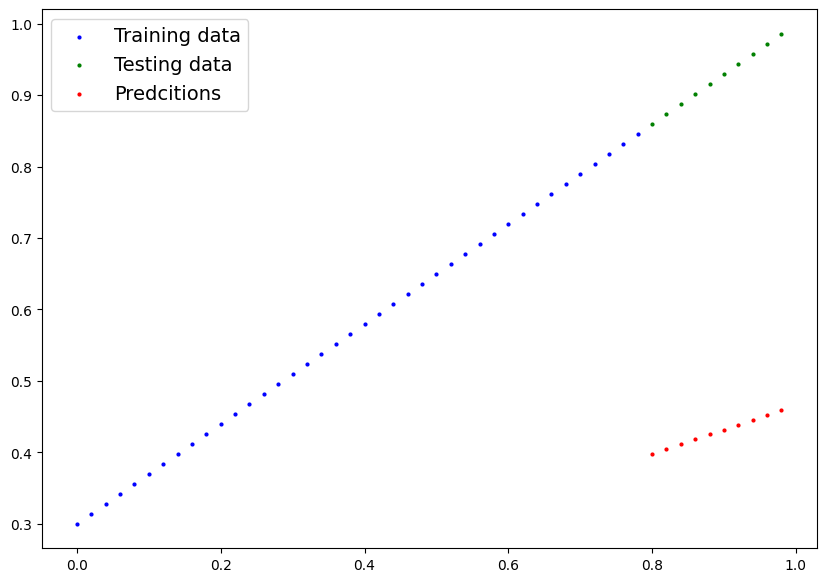

In [ ]:
# Plot predictions.
plot_predictions(predictions = y_preds)

### Training model

Things needed to train:
* **Loss Function**
* **Optimizer**

Specifically for PyTorch:
* A training loop.
* A testing loop.

In [ ]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [ ]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [ ]:
# Setup a loss function.
loss_fn = nn.L1Loss()

# Setup a optimizer.
optimizer = torch.optim.SGD(model_0.parameters(),
                            lr= 0.01) # Learning rate.

### Building a training loop

Things needed in a training loop.
1. Loop through the data.
2. Forward pass[propagation]. This involves data mvoing through our model's `forward()` to make predictions on data.
3. Calculate the loss. (compare forward pass predictions to ground truth labels.)
4. Optimizer zero grad.
5. Loss backward. Moves backward through the netwrok to  calculate the gradients of each of the parameters of our model with respect to the loss. (**backpropagation**)
6. Optimizer step - use optimizer to adjust the model parameters to try and improve the loss. (**gradient descent**)

In [ ]:
torch.manual_seed(42)

# An epoch is one loop through the data.
epochs = 200

#Keeping track of model progress.
epoch_count = []
loss_values = []
test_loss_values = []

### Training.
#Loop through the data.
for epoch in range(epochs):
  # Set the model to training mode.
  model_0.train() # Turns on all gradient tracking.

  # Forward pass.
  y_pred = model_0(X_train)

  # Calculate the loss.
  loss = loss_fn(y_pred, y_train)
  print(f"Loss: {loss}")

  # Optimizer zero grad.
  optimizer.zero_grad()

  # Perform back propagation on the loss with respect to the parameters of the model.
  loss.backward()

  # Step the optimizer.
  optimizer.step()

  ### Testing
  model_0.eval() #turns off different settings in the model.
  with torch.inference_mode():
    #1.Do forward pass.
    test_pred = model_0(X_test)

    #2.Calculate the loss.
    test_loss = loss_fn(test_pred, y_test)

  if epoch%10 ==0:
    epoch_count.append(epoch)
    loss_values.append(loss_values)
    test_loss_values.append(test_loss_values)

    print(f"Epoch: {epoch} | Test loss: {test_loss}")
    #Print model.
    print(model_0.state_dict())

Loss: 0.31288138031959534
Epoch: 0 | Test loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Loss: 0.3013603389263153
Loss: 0.28983935713768005
Loss: 0.2783183455467224
Loss: 0.26679736375808716
Loss: 0.2552763521671295
Loss: 0.24375534057617188
Loss: 0.23223432898521423
Loss: 0.22071333229541779
Loss: 0.20919232070446014
Loss: 0.1976713240146637
Epoch: 10 | Test loss: 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Loss: 0.18615034222602844
Loss: 0.1746293306350708
Loss: 0.16310831904411316
Loss: 0.1515873372554779
Loss: 0.14006635546684265
Loss: 0.1285453587770462
Loss: 0.11702437698841095
Loss: 0.1060912236571312
Loss: 0.09681284427642822
Loss: 0.08908725529909134
Epoch: 20 | Test loss: 0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Loss: 0.08227583020925522
Loss: 0.07638873159885406
Loss: 0.07160007208585739
Loss: 0.06747635453939438
Loss: 0.0639

In [ ]:
# import numpy as np
# # Plot the loss curve.
# plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label = "Train Loss")
# plt.plot(epoch_count, test_loss_values, label = "Test Loss")
# plt.title("Training and Testing loss curves")
# plt.ylabel("Loss")
# plt.xlabel("Epoch")
# plt.legend();

In [ ]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

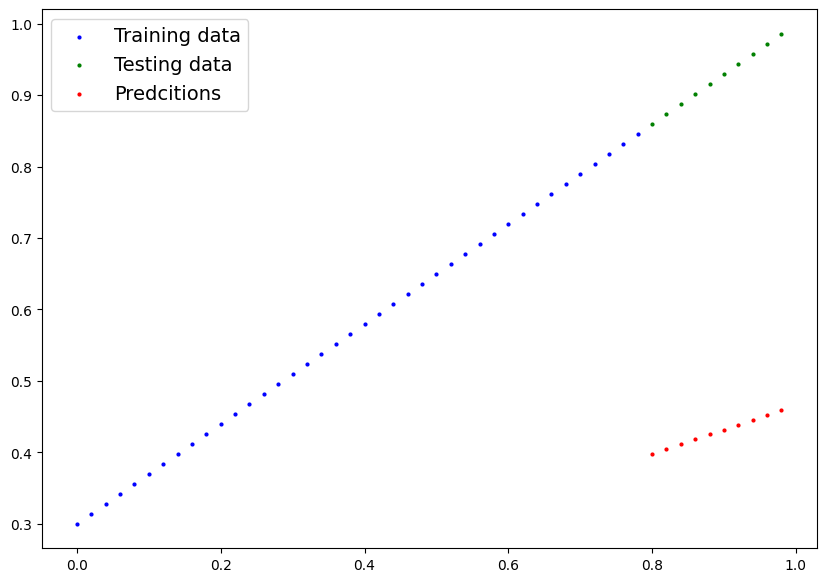

In [ ]:
plot_predictions(predictions = y_preds)

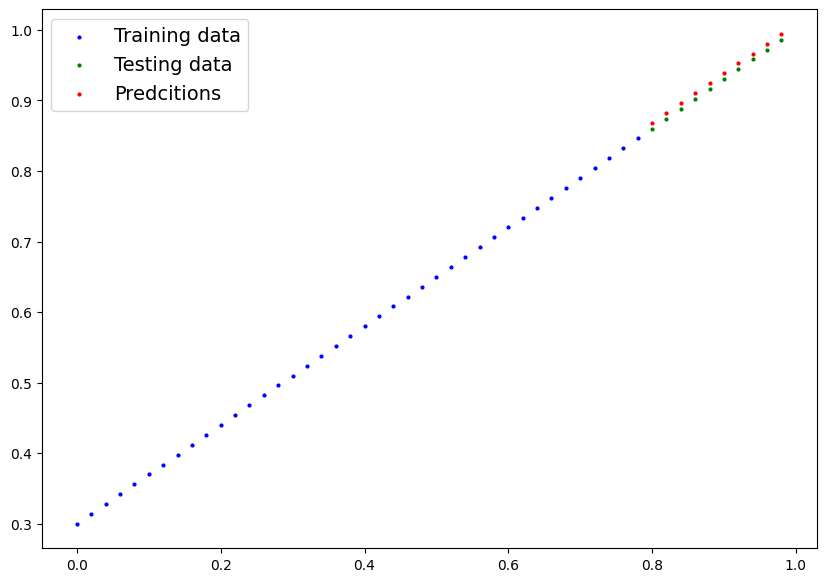

In [ ]:
plot_predictions(predictions = y_preds_new)

### Saving and loading model.

Three main methods:
1. `torch.save()` - allows to save in pickle format.
2. `torch.load()` - allows to save in PyTorch object.
3. `torch.nn.Module.load_state_dict()` - allows to save model in state dictionary.

In [ ]:
# Saving model
from pathlib import Path

#1.Create model directory.
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

#2. Create model save path.
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
MODEL_SAVE_PATH

#3. Save the model state dict.
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj = model_0.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


### Loading saved model.

In [ ]:
# To load in a saved state dict.
loaded_model_0 = LinearRegressionModel()

# Load the saved state dict.
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [ ]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [ ]:
# Making some predictions with our loaded model.
loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [ ]:
# Make some models preds.
model_0.eval()
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [ ]:
# Compare loaded model with original model preds checking if they are same or not.
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])